# Efficient Frontier & Portfolio Optimization
**Goal:** Build mean-variance optimizer, plot efficient frontier, compute minimum-variance and max-Sharpe portfolios.

This notebook works offline using synthetic data. To use real data, uncomment yfinance code when running in Colab.


In [2]:
# Install if needed (run once)
!pip install yfinance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Optional for real data:
import yfinance as yf

plt.style.use('default')


In [3]:
# --- Option A: Real data via yfinance (uncomment to use) ---
# tickers = ['AAPL','MSFT','GOOG','AMZN']
# data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
# prices = data.dropna()

# --- Option B: Synthetic data (offline-safe) ---
np.random.seed(42)
dates = pd.date_range('2020-01-01', periods=500)
tickers = ['AAPL','MSFT','GOOG','AMZN']
prices = pd.DataFrame(100 + np.cumsum(np.random.randn(500, len(tickers)), axis=0),
                      index=dates, columns=tickers)

prices.head()


,AAPL,MSFT,GOOG,AMZN
2020-01-01,100.496714,99.861736,100.647689,101.523030
2020-01-02,100.262561,99.627599,102.226901,102.290465
2020-01-03,99.793086,100.170159,101.763484,101.824735
2020-01-04,100.035049,98.256879,100.038566,101.262447
2020-01-05,99.022218,98.571126,99.130542,99.850144


In [4]:
returns = prices.pct_change().dropna()
mu = returns.mean() * 252       # annualized expected returns
Sigma = returns.cov() * 252     # annualized covariance
mu, Sigma.iloc[:3,:3]

(AAPL    0.074485
 MSFT    0.153930
 GOOG    0.095733
 AMZN    0.114265
 dtype: float64,
           AAPL      MSFT      GOOG
 AAPL  0.020389 -0.000702 -0.001135
 MSFT -0.000702  0.023335 -0.000333
 GOOG -0.001135 -0.000333  0.021956)

In [5]:
def portfolio_performance(weights, mu, Sigma, risk_free=0.0):
    ret = np.dot(weights, mu)
    vol = np.sqrt(weights.T @ Sigma @ weights)
    sharpe = (ret - risk_free) / vol if vol != 0 else 0.0
    return ret, vol, sharpe

def minimize_volatility(weights, mu, Sigma):
    return np.sqrt(weights.T @ Sigma @ weights)

def neg_sharpe(weights, mu, Sigma, risk_free=0.02):
    ret, vol, _ = portfolio_performance(weights, mu, Sigma, risk_free)
    return - (ret - risk_free) / vol


In [6]:
n = len(mu)
x0 = np.ones(n) / n
bounds = tuple((0,1) for _ in range(n))
cons = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1},)

# Minimum variance
min_var = minimize(minimize_volatility, x0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)
w_minvar = min_var.x

# Maximum Sharpe
max_sh = minimize(neg_sharpe, x0, args=(mu, Sigma, 0.02), method='SLSQP', bounds=bounds, constraints=cons)
w_maxsh = max_sh.x

print("Min-Var weights:", dict(zip(tickers, np.round(w_minvar,4))))
print("Max-Sharpe weights:", dict(zip(tickers, np.round(w_maxsh,4))))


Min-Var weights: {'AAPL': np.float64(0.2782), 'MSFT': np.float64(0.2336), 'GOOG': np.float64(0.2548), 'AMZN': np.float64(0.2334)}
Max-Sharpe weights: {'AAPL': np.float64(0.1814), 'MSFT': np.float64(0.3499), 'GOOG': np.float64(0.2181), 'AMZN': np.float64(0.2506)}


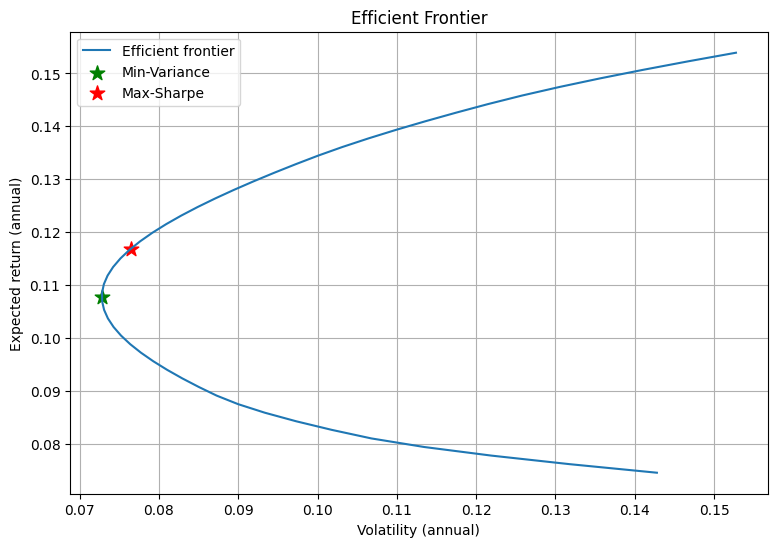

In [7]:
target_returns = np.linspace(mu.min(), mu.max(), 50)
frontier_vol = []

for tr in target_returns:
    constraints = (
        {'type':'eq','fun': lambda w: np.sum(w)-1},
        {'type':'eq','fun': lambda w, tr=tr: np.dot(w, mu)-tr}
    )
    res = minimize(minimize_volatility, x0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=constraints)
    frontier_vol.append(res.fun if res.success else np.nan)

ret_min, vol_min, _ = portfolio_performance(w_minvar, mu, Sigma)
ret_sh, vol_sh, _ = portfolio_performance(w_maxsh, mu, Sigma)

plt.figure(figsize=(9,6))
plt.plot(frontier_vol, target_returns, label='Efficient frontier')
plt.scatter(vol_min, ret_min, marker='*', color='g', s=120, label='Min-Variance')
plt.scatter(vol_sh, ret_sh, marker='*', color='r', s=120, label='Max-Sharpe')
plt.xlabel('Volatility (annual)')
plt.ylabel('Expected return (annual)')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()


### Extensions
- Add transaction costs or turnover penalty.
- Allow short-sales (remove bounds).
- Use real data via yfinance and compare over different periods.
